In [19]:
import numpy as np 
import numpy.random as npr
import matplotlib.pyplot as plt 
import scipy.stats as stats 
import scipy.linalg as linalg
from tqdm import tqdm
import time
import math
from scipy.integrate import quad
from gaussian_tails import coupling_gaussian_distributions
np.random.seed(6789)
import warnings
warnings.filterwarnings("ignore")

## Notations 

Toutes les variables aléatoires sont définies sur un espace de probabilité $ (\Omega, \mathcal{F}, \mathbb{P}) $ et prennent leurs valeurs dans un espace mesurable $ \mathbb{X} $ qui est $ \mathbb{Z} $ ou $ \mathbb{R} ^d $. 

- $ X \sim p $ : $X $ admet une densité par rapport à la mesure de Lebesgue ou de comptage. 

- $ Y \sim q $

- $ \frac{ d \mathbb{P} _{(X,Y)}}{d \lambda} := \Gamma $

- $ U_n \sim V_n $ ssi $ \frac{U_n}{V_n} \to 1 $ quand $n \to + \infty $

## Plan 

- ##### Introduction 

- ##### Méthode d'échantillonnage par rejet couplé, suivi d'un exemple

- ##### Algorithme de Relection Coupling

- ##### Application 1 : Liaison des queues des distributions gaussiennes

- ##### Application 3 : Coupled Gibbs sampling

- ##### Application à Metropolis-Hastings

- ##### Algorithme de Thorisson 

## Introduction 

Si $(X_t)_t$ et $(Y_t)_t$ sont des chaînes de Markov, le temps de couplage est défini comme : $\text{inf} \{t \ge 0 : X_t = Y_t \}$. 

On propose une illustration à partir de [l'article](https://proceedings.mlr.press/v130/wang21d/wang21d.pdf) de O’Leary, Wang et Jacob. 

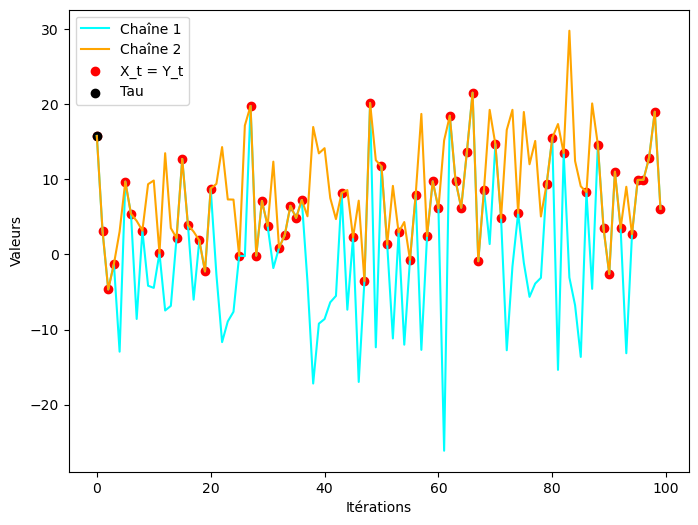

In [20]:
def algorithm2(values, length):
    def normal_mean(value, evaluate):
        """  Densité d'une loi normale de moyenne value et de variance 10, évaluée en evaluate      
        """
        return np.exp(-(evaluate - value)**2 / 20) / (np.sqrt(20 * np.pi))
    simulation = []

    for i in range(length):
        x2, U = npr.normal(values[0], 10), npr.uniform()
        rapport = normal_mean(values[1], x2) / normal_mean(values[0], x2)
        if U <= rapport: 
            y2 = x2
        else: 
            repeat = True 
            while repeat: 
                y3, V = npr.normal(values[1], 10), npr.uniform()
                rapport = normal_mean(values[0], y3) / normal_mean(values[1], y3)
                if rapport <= V: 
                    y2 = y3
                    repeat = False
        simulation.append([i, x2, y2])
    return np.array(simulation) 

simulation = algorithm2(np.array([0.25, 4]), 10**2)
plt.figure(figsize=(8,6))
plt.plot(simulation[:,0], simulation[:,1], label = "Chaîne 1", color = "cyan")
plt.plot(simulation[:,0], simulation[:,2], label = "Chaîne 2", color = 'orange')
plt.scatter(simulation[simulation[:,1] == simulation[:,2]][:,0], simulation[simulation[:,1] == simulation[:,2]][:,1], color='red', label="X_t = Y_t")
plt.scatter(simulation[simulation[:,1] == simulation[:,2]][0,0],simulation[simulation[:,1] == simulation[:,2]][0,1], color='black', label="Tau")
plt.plot()
plt.xlabel("Itérations")
plt.ylabel("Valeurs")
plt.legend()
plt.show()

## Méthode d'échantillonnage par rejet couplé

$\textbf{Definition 1}$ : Un couple de variables aléatoires $ (X, Y)$ défini sur le même espace de probabilité et prenant ses valeurs dans $ \mathcal{X} $ est un couplage diagonal de probabilités $p$ et $q$ si, et seulement si, c'est un couplage tel que : 

- $ \mathbb{P} (X \in A) = \displaystyle \int _{A} p(x) dx $ 

- $ \mathbb{P} (Y \in A) = \displaystyle \int _{A} q(x) dx $, $ \forall A \subset \mathcal{X}$ 

- $ \mathbb{P} (X = Y) > 0$

Avec cette définition, un couplage maximal est un couplage diagonal de masse maximale sur l'évènement $ \{ X = Y \}$. 


$\textbf{Definition 2}$ : Soient $( \hat{p}, \hat{q}) $ une paire de densités de probabilité. On dit que $( \hat{p}, \hat{q}) $ domine $ (p,q) $ ou on écrit $( \hat{p}, \hat{q}) \succeq ( \hat{p}, \hat{q}) $ ssi il existe $ 1 \le M(p, \hat{p}) < + \infty$ , $ 1 \le M(q, \hat{q}) < + \infty$ tel que $ \forall x \in \mathbb{R} ^d$ on ait : $ p(x) \le M(p, \hat{p}) \hat{p} (x) $ , $ q(x) \le M(q, \hat{q}) \hat{q} (x) $.

Attention ! Ce n'est pas parce que nous avons de tels $( \hat{p}, \hat{q}) \succeq ( \hat{p}, \hat{q}) $ que $ \hat{ \Gamma } \succeq \Gamma $. 


Supposons que nous disposons de tels $( \hat{p}, \hat{q}) \succeq ( \hat{p}, \hat{q}) $ et de  $\hat{ \Gamma } \succeq \Gamma $. Nous pouvons alors proposer l'allgorithme suivant :



### Acceptation-rejet de (p, q):

In [21]:
def RejectionCoupling(GammaH, p, q, pH, qH, M_p, M_q):
    """  Rejection Coupling (Algorithm1)
    GammaH (H pour Hat) représentant le couplage définit plus haut. 
    Dans le papier, on suppose que lorsque les marginales_hat dominent les marginales, 
    alors gamma_hat domine gamma (attention, en réalité ça n'est pas vrai ...)

    Paramètres
    ----------
    
    GammaH : Fonction gamma_hat qui domine gamma
    p : marginale 1 
    q = marginale 2
    pH : marginale 1 de GammaH qui domine p
    qH : marginale 2 de GammaH qui domine q
    M_p : Ratio tel quel p / pH <= M_p
    M_q : Ratio tel quel q / qH <= M_q
    """
    AX, AY = 0, 0
    while AX == 0 & AY == 0: 
        X1, Y1 = GammaH.rvs()
        U = npr.uniform()
        if U <= p.rvs(X1) / (M_p * pH.rvs(X1)):
            AX = 1
        if U <= q.rvs(Y1) / (M_q * qH.rvs(Y1)):
            AY = 1
    X2, Y2 = p.rvs(), q.rvs()
    return AX * X1 + (1-AX) * X2, AY * Y1 + (1-AY) * Y2

L'algorithme Rejection Coupling vise à simuler des échantillons à partir d'une distribution bidimensionnelle avec des marginales données par les lois $p$ et $q$. Voici le fonctionnement de l'algorithme proposé par l'article :

1. **Choix des distributions auxiliaires** : On choisit des distributions auxiliaires $\hat{p}$ et $\hat{q}$ qui dominent respectivement $p$ et $q$, et un tatio maximal $M_p$ et $M_q$ pour limiter le rejet.

2. **Génération de paires aléatoires** : On génère des paires de variables aléatoires $X_1$ et $Y_1$ dont le couple suit la loi $\hat{\Gamma}$.

3. **Test de rejet pour $p$ et $q$** : Pour chaque paire $(X_1, Y_1)$, on teste si elle est acceptée en comparant un échantillon $U$ tiré d'une distribution uniforme avec le rapport de densité entre $p$ (ou $q$) et $\hat{p}$ (ou $\hat{q}$), multiplié par un facteur de rejet. Si l'échantillon est accepté pour $p$ (ou $q$), il fixe le bit $AX$ (ou $AY$) à 1.

4. **Génération de paires de rechange** : Après la boucle while, on génère de nouvelles paires de variables aléatoires $X_2$ et $Y_2$ à partir des distributions $p$ et $q$, indépendamment du résultat de la boucle while.

5. **Combinaison des paires** : On combine les paires acceptées et générées pour former les échantillons finaux $X$ et $Y$ en utilisant les bits $AX$ et $AY$. Si $AX$ (ou $AY$) est égal à 1, on utilise la valeur correspondante de $X_1$ (ou $Y_1$), sinon on utilise la valeur correspondante de $X_2$ (ou $Y_2$).

En utilisant les distributions auxiliaires qui dominent les distributions cibles, l'algorithme réduit le nombre d'échantillons rejetés, augmente la probabilité d'acceptation des échantillons et améliore l'efficacité de l'échantillonnage.

**NB**. Les distributions auxiliaires $\hat{p}$ et $\hat{q}$ sont choisies de telle manière qu'elles dominent respectivement $p$ et $q$. Cela signifie que les valeurs de densité de probabilité de $p$ et $q$ sont toujours inférieures ou égales à celles de $\hat{p}$ et $\hat{q}$ . Ainsi, le rapport de densité $p/\hat{p}$ et $q/\hat{q}$ est toujours inférieur ou égal à 1. En utilisant ces rapports de densité comme critères d'acceptation, les échantillons sont plus susceptibles d'être acceptés par rapport à une distribution qui ne domine pas la cible. Cela réduit le nombre d'échantillons rejetés.

### Exemple : 

On souhaite coupler deux lois normales de paramètres $0,1$, c'est-à-dire simuler un couple de variables aléatoires dont les marginales sont des lois normales $\mathcal{N}(0,1)$. 

Pour cela, on majore les densités $p(x) = q(x) = \frac{1}{\sqrt{2 \pi}} e^{- \frac{x ^2}{2}}$ par $ \hat{p} (x) = \hat{q} (x) = 2 e^{-2x}$. 

Nous avons : $ \frac{p(x)}{\hat{p} (x)} \le \sqrt{ \frac{2}{ \pi}} e^{- \frac{(x-2)^2}{2} + 2} \le \sqrt{ \frac{2}{ \pi}} e^{2}$. 

Pour simuler GammaH, nous utilisons la méthode de la transformée inverse. Pour cela, nous modifions légèrement l'algorithme ci-dessus :

In [22]:
def RejectionCoupling_application(p, q, pH, qH, M_p, M_q):
    """  Rejection Coupling (Algorithm1)
    GammaH (H pour Hat) représentant le couplage définit plus haut. 
    Dans le papier, on suppose que lorsque les marginales_hat dominent les marginales, 
    alors gamma_hat domine gamma (attention, en réalité ça n'est pas vrai ...)

    Paramètres
    ----------

    p : marginale 1 
    q = marginale 2
    pH : marginale 1 de GammaH qui domine p
    qH : marginale 2 de GammaH qui domine q
    M_p : Ratio tel quel p / pH <= M_p
    M_q : Ratio tel quel q / qH <= M_q
    """
    def simul_exp2(scale=2):
        U, V = np.random.uniform(), np.random.uniform()
        X, Y = -scale * np.log(1 - U), -scale * np.log(1 - V)
        return np.vstack((X, Y)).T
    tau = 0 
    AX, AY = 0, 0
    temps_acceptation = 0
    debut = time.time()
    while AX == 0 & AY == 0: 
        vecteur = simul_exp2()
        X1, Y1 = vecteur[0][0], vecteur[0][1]
        U = npr.uniform()
        if U <= p.pdf(X1) / (M_p * pH.pdf(X1)):
            AX = 1
        if U <= q.pdf(Y1) / (M_q * qH.pdf(Y1)):
            AY = 1
    fin = time.time()
    temps_acceptation = fin - debut
    X2, Y2 = p.rvs(), q.rvs()
    return (AX * X1 + (1-AX) * X2, AY * Y1 + (1-AY) * Y2, temps_acceptation)

100%|██████████| 100000/100000 [01:31<00:00, 1096.68it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


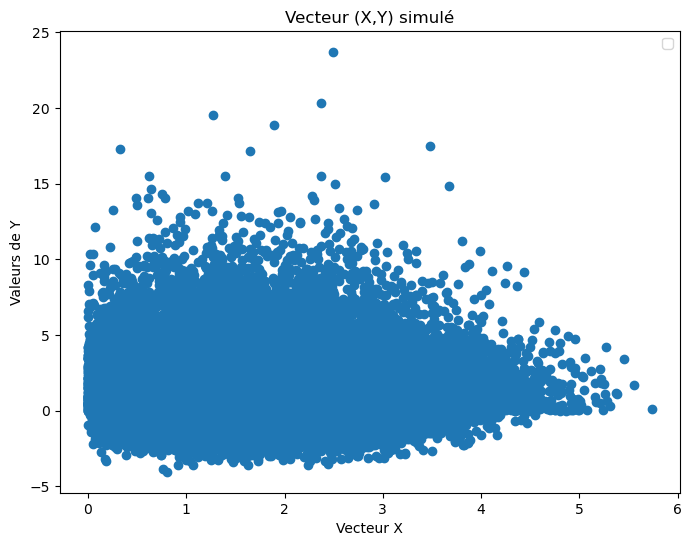

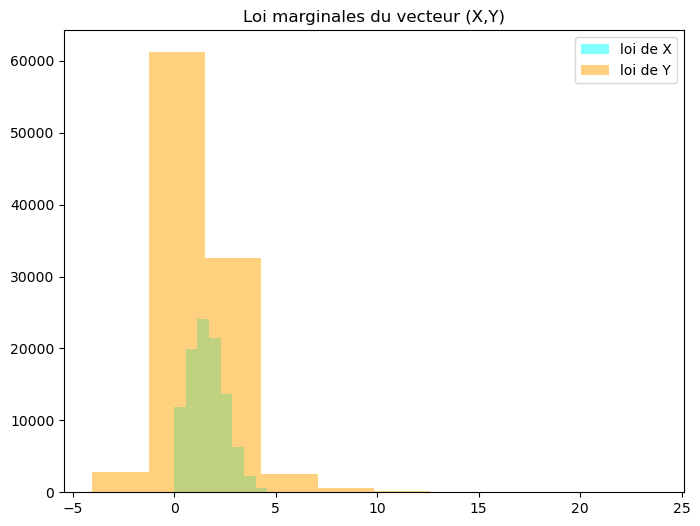

In [23]:
n = 10**5  #nombre de simulations
Mp, Mq = np.sqrt(2 / np.pi) * np.exp(2), np.sqrt(2 / np.pi) * np.exp(2)
p, q = stats.norm(), stats.norm()
pH, qH = stats.expon(scale = 1/2), stats.expon(scale = 1/2)

valeurs_de_X = []
valeurs_de_Y = []
temps_acceptation = []
for _ in tqdm(range(n)):
    X, Y, temps = RejectionCoupling_application(p, q, pH, qH, Mp, Mq)
    temps_acceptation.append(temps)
    valeurs_de_X.append(X)
    valeurs_de_Y.append(Y)
plt.figure(figsize=(8,6))
plt.scatter(valeurs_de_X, valeurs_de_Y)
plt.xlabel("Vecteur X")
plt.ylabel("Valeurs de Y")
plt.title("Vecteur (X,Y) simulé")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.hist(valeurs_de_X, color = "cyan", alpha = 0.5, label = "loi de X")
plt.hist(valeurs_de_Y, color = "orange", alpha = 0.5,  label = "loi de Y")
plt.title("Loi marginales du vecteur (X,Y)")
plt.legend()
plt.show()

Sans fixer de seuil, on obtient $P(X=Y) = 0$ car les distributions ne sont pas exactement les mêmes. Étant donné que l'on échantillonne des lois normales qui sont centrées en $0$, on propose donc un seuil fixé autour de $0$ de l'ordre de quelques $10^{-n}$ avec $n = 3 \text{ ou } 4$. Dans ce cas, on a une probabilité non nulle que $P(X=Y)$ car on accepte une différence faible entre les distributions. 

In [24]:
# On veut calculer la probabilité que X = Y
eps = 1e-4  # Seuil epsilon
count = sum(1 for i in range(n) if abs(valeurs_de_X[i] - valeurs_de_Y[i]) < eps)
proba = count / n
print("La probabilité que X = Y est :", proba)

La probabilité que X = Y est : 4e-05


In [25]:
# Calcul de la moyenne empirique
moyenne = np.mean(temps_acceptation)

# Calcul de la variance empirique
variance_empirique = np.mean((temps_acceptation - moyenne) ** 2)

print("Moyenne empirique :", moyenne)
print("Variance empirique :", variance_empirique)
print("Écart-type :", math.sqrt(variance_empirique))

Moyenne empirique : 0.0008848937082290649
Variance empirique : 6.871914395165521e-07
Écart-type : 0.0008289701077340196


## Algorithme de "Reflection Coupling"

Nous nous concentrons maintenant sur le cas spécial important du couplage de distributions gaussiennes d-dimensionnelles avec des moyennes et des covariances différentes.

La probabilité de succès du couplage tient au fait que $M(\hat{p},p) \text{ et } M(\hat{q},q)$ doivent être aussi proches que possible de 1 (pour ne pas trop dégrader la probabilité de couplage). Ce qui rend la tâche de couplage plus ardue.  

En effet, la probabilité de succès du couplage dépend fortement de la probabilité d'acceptation des marginales dans l'étape d'acceptation-rejet. En grande dimension, cette probabilité d'acceptation tend vers 0 donc la probabilité de succès  du couplage également. En considérant plusoeurs propositionnelles, on augmente la probabilité d'acceptation des marginales sans faire trop varier le temps d'exécution.

**NB.**
Dans ce cas néanmoins, les quantités $X,Y,P(X=Y)$ dépendent implicitement du nombre $N$ de propositionnelles. 


In [26]:
def ReflectionCoupling(a, b, sigma): 
    """  ReflectionCoupling : méthode de Bou-Rabee et al. (2020)
    Initialisation : deux vecteurs a et b représentant les moyennes des distributions à coupler, 
    et une matrice de covariance sigma.

    Cet algorithme permet de coupler deux distributions multivariées en ajustant les vecteurs aléatoires X et Y pour 
    qu'ils respectent les moyennes et les covariances spécifiées par les vecteurs a et b et la matrice de covariance sigma.
    """
    d = sigma.shape[0]
    sigma_inverse = linalg.inv(sigma)
    z = np.dot(linalg.sqrtm(sigma_inverse), (a - b))
    e = z / linalg.norm(z)
    multivariate_normal = stats.multivariate_normal(mean = np.zeros(d), cov = np.eye(d))
    X, U = multivariate_normal.rvs(), npr.uniform()
    if multivariate_normal.pdf(X) * U < multivariate_normal.pdf(X + z):
        Y = X + z
    else:
        Y = X - 2 * np.dot(X, e) * e
    X2, Y2 = a + np.dot(linalg.sqrtm(sigma), X), b + np.dot(linalg.sqrtm(sigma), Y)
    return X2, Y2

### Simulation :

In [27]:
def generer_matrice_inversible(d):
    """ 
    Permet de générer une matrice aléatoire de taille d, inversible.
    """
    matrice = np.random.rand(d, d)
    if np.linalg.matrix_rank(matrice) == d:
        return matrice

Matrice aléatoire :
 [[0.57, 0.15, 0.76, 0.58, 0.66],
 [0.57, 0.71, 0.13, 0.28, 0.53],
 [0.95, 0.43, 0.96, 0.01, 0.02],
 [0.54, 0.33, 0.84, 0.1 , 0.81],
 [0.52, 0.67, 0.83, 0.53, 0.15]]


100%|██████████| 100000/100000 [00:27<00:00, 3595.77it/s]


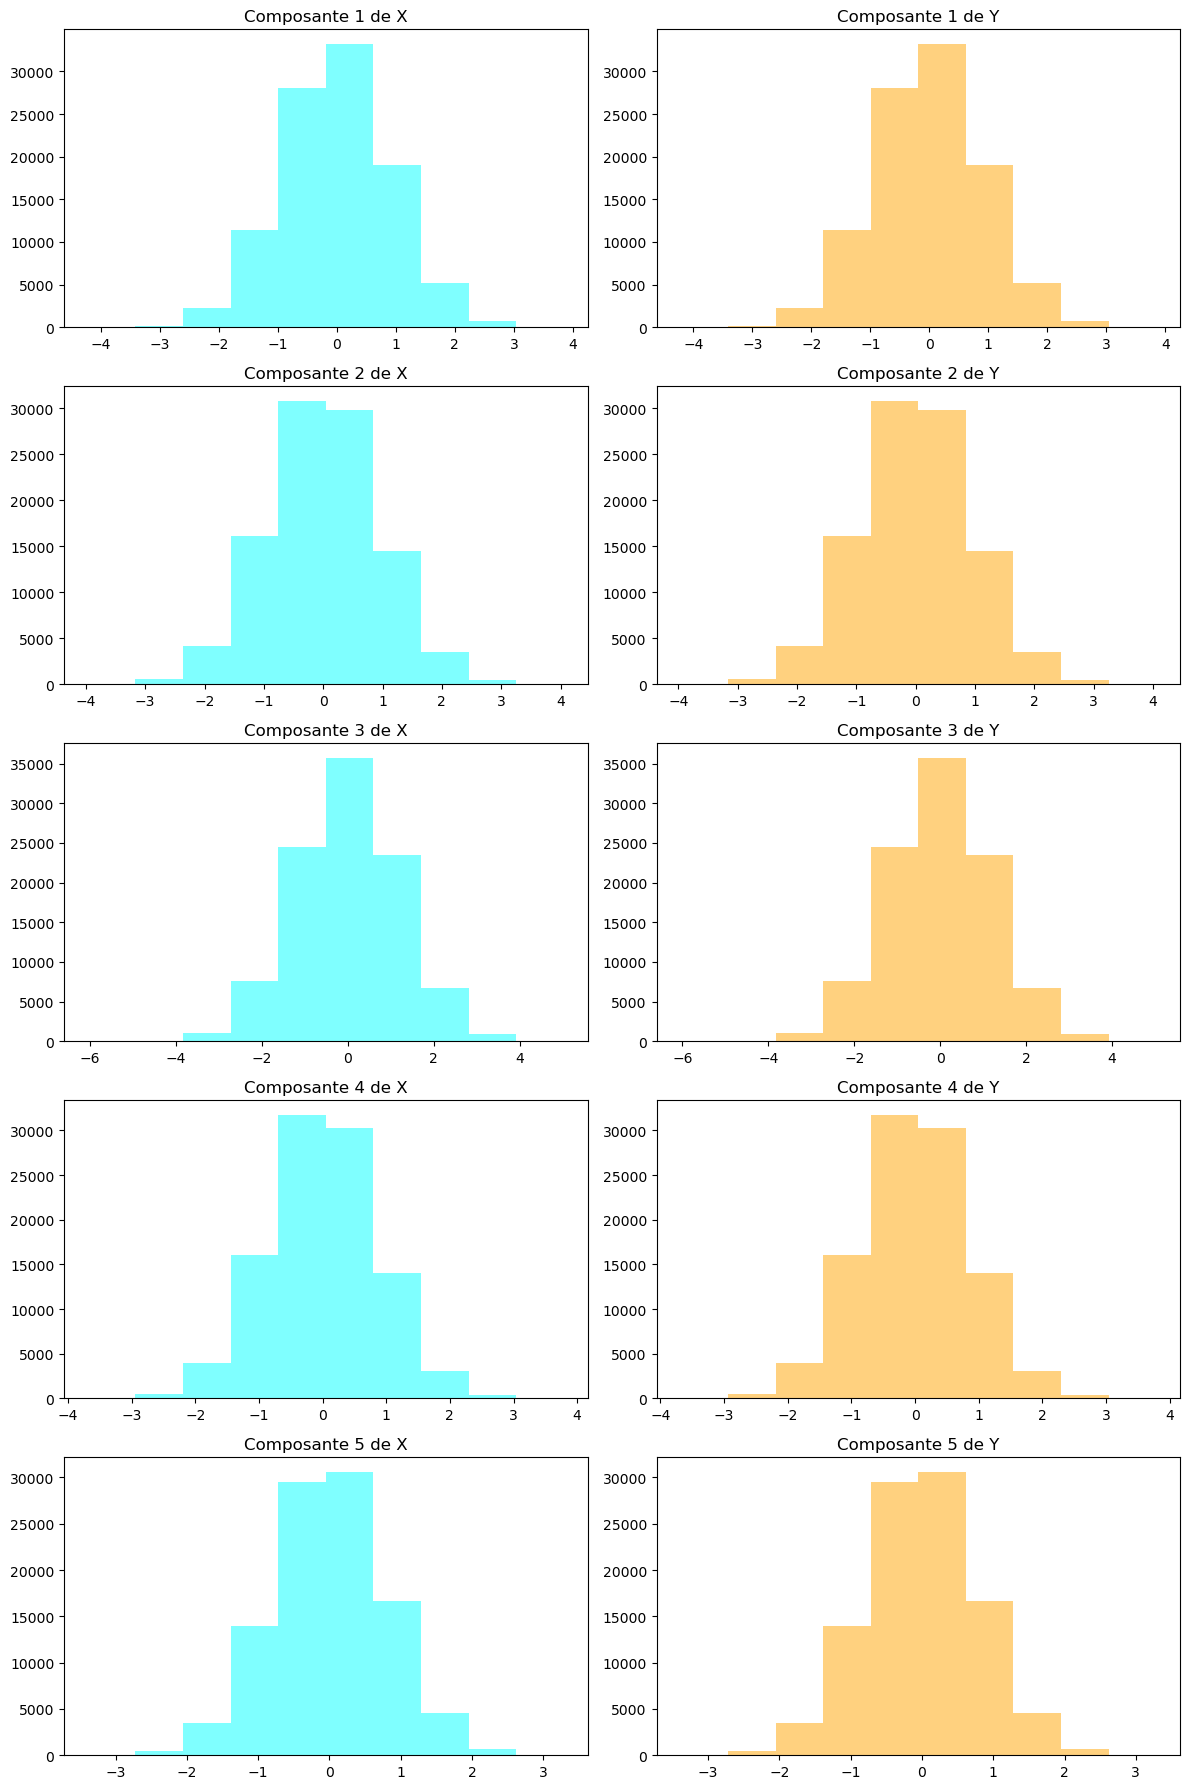

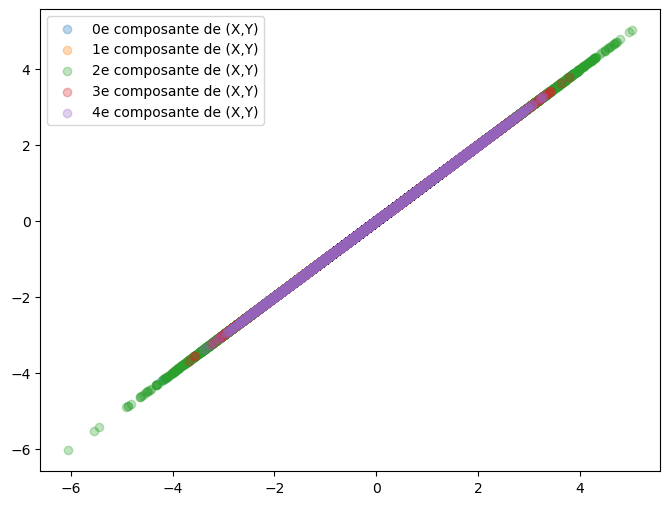

In [28]:
n = 10**5  #nombre de simulations
a = np.zeros(5)
b = np.zeros(5)
sigma = generer_matrice_inversible(5)
print("Matrice aléatoire :\n", np.array2string(sigma, precision=2, separator=', ', suppress_small=True))

valeurs_de_X = []
valeurs_de_Y = []
for _ in tqdm(range(n)):
    X, Y = ReflectionCoupling(a, b, sigma)
    valeurs_de_X.append(X)
    valeurs_de_Y.append(Y)

valeurs_de_X = np.array(valeurs_de_X)
valeurs_de_Y = np.array(valeurs_de_Y)
fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i in range(5):
    axs[i, 0].hist(valeurs_de_X[:,i], color="cyan", alpha=0.5)
    axs[i, 0].set_title(f"Composante {i+1} de X")

    # Affichage de l'histogramme de la i-ème composante de Y
    axs[i, 1].hist(valeurs_de_Y[:,i], color="orange", alpha=0.5)
    axs[i, 1].set_title(f"Composante {i+1} de Y")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
for i in range(5):
    plt.scatter(valeurs_de_X[:,i], valeurs_de_Y[:,i], label = f"{i}e composante de (X,Y)", alpha = 0.3)
plt.legend()
plt.show()

Toutes les composantes sont donc bien distribuées selon la bissectrice avec des valeurs plus ou moins éparses.

## Application 1 : Liaison des queues des distributions gaussiennes

Soient $X \sim \mathcal{N}(0,1), Y \sim \mathcal{N}(0,1)$.

Introduisons $X_{\mu} = X | X > \mu$ de densité par rapport à la mesure de lebesgue $ p_{\mu}$ et $Y_{\eta} = Y | Y > \eta$ de densité par rapport à la mesure de lebesgue $ q_{\eta}$.

Lorsque $\mu , \eta $ deviennent grand, on ne peut plus utliser la méthode d'inversion pour simuler $p$ et $q$, nous devons voir recours à la méthode d'échantillonnage par rejet. 

On utilise une loi exponentielle translatée comme proposition : $\text{Exp} (x; m, \lambda) = \lambda e^{- \lambda (x-m)} \textbf{1} (x \ge m)$.

Sans pertes de généralités, on suppose que $ \eta > \mu $.

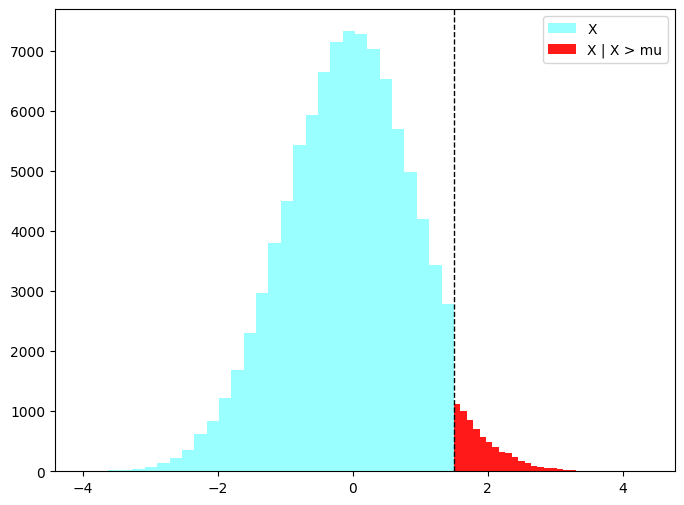

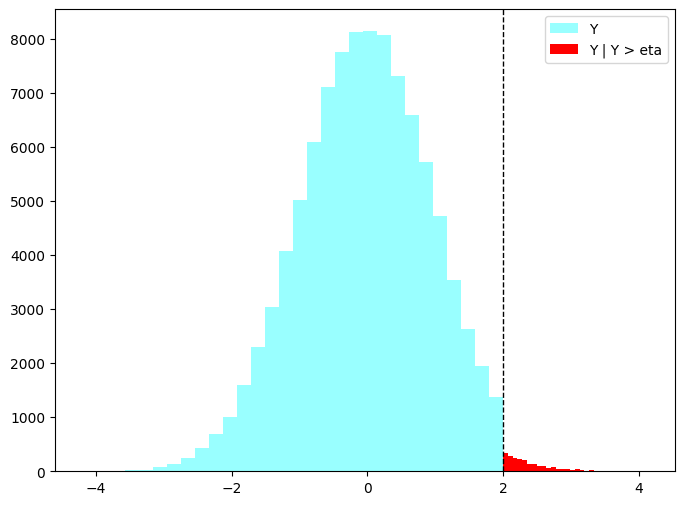

In [151]:
n = 10**5
mu, eta = 1.5, 2
X = npr.normal(0, 1, size=n)
X_filtre = X[X<=mu]
X_mu = X[X>mu]
Y = npr.normal(0, 1, size=n)
Y_filtre = Y[Y<=eta]
Y_eta = Y[Y>eta]

plt.figure(figsize=(8,6))
plt.hist(X_filtre, bins = 30, label = "X", color = "cyan", alpha = 0.4)
plt.hist(X_mu, bins = 30, label = "X | X > mu", color = "red", alpha = 0.9)
plt.axvline(x=mu, color='k', linestyle='--', linewidth=1)
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.hist(Y_filtre, bins = 30, label = "Y", color = "cyan", alpha = 0.4)
plt.hist(Y_eta, bins = 30, label = "Y | Y > eta", color = "red")
plt.axvline(x=eta, color='k', linestyle='--', linewidth=1)
plt.legend()
plt.show()

In [152]:
# Définition des fonctions utiles dans l'application
def alpha(z):
    return((z+np.sqrt(z**2 + 4))/2)

def fonction(x, z):
    return(np.exp(-(x-alpha(z))**2/2))

In [153]:
def RejectionCoupling_application1(p, q, mu, eta):
    """  Rejection Coupling (Algorithm1)
    GammaH (H pour Hat) représentant le couplage définit plus haut. 
    Dans le papier, on suppose que lorsque les marginales_hat dominent les marginales, 
    alors gamma_hat domine gamma (attention, en réalité ça n'est pas vrai ...)

    Paramètres
    ----------

    p : marginale 1 
    q : marginale 2
    mu : paramètre seuil
    eta : paramètre seuil
    """
    def simul_exp2(mu, eta):
        U, V = np.random.uniform(), np.random.uniform()
        X, Y = -np.log(1 - U)/alpha(mu) + mu, -np.log(1 - V)/alpha(eta) + eta
        return np.vstack((X, Y)).T
    tau = 0 
    AX, AY = 0, 0
    temps_acceptation = []
    debut = time.time()
    while AX == 0 & AY == 0: 
        vecteur = simul_exp2(mu, eta)
        X1, Y1 = vecteur[0][0], vecteur[0][1]
        U = npr.uniform()
        if U <= fonction(X1,mu):
            AX = 1
        if U <= fonction(Y1,eta):
            AY = 1
    fin = time.time()
    temps_acceptation.append(fin-debut)
    test = 0
    while test == 0:
        X2, Y2 = p.rvs(), q.rvs()
        if X2 > mu and Y2 >eta :
            test = 1
    return (AX * X1 + (1-AX) * X2, AY * Y1 + (1-AY) * Y2, temps_acceptation)

In [156]:
n = 10**4  #nombre de simulations
mu, eta = 1.5, 2  

p, q = stats.norm(), stats.norm()

100%|██████████| 10000/10000 [10:42<00:00, 15.58it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


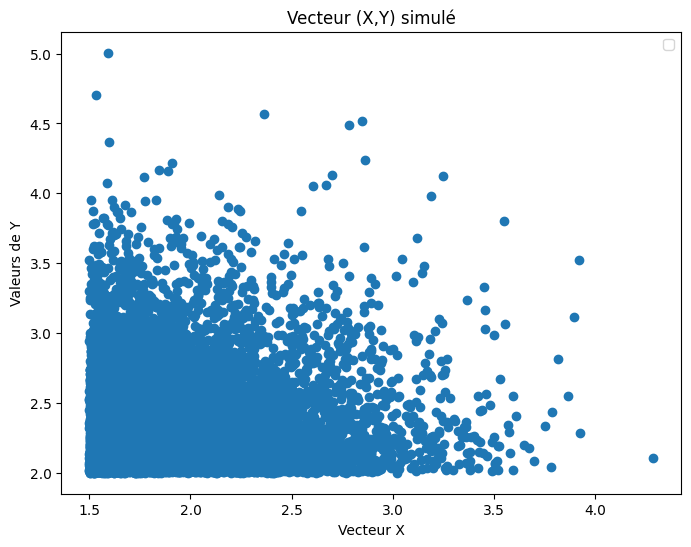

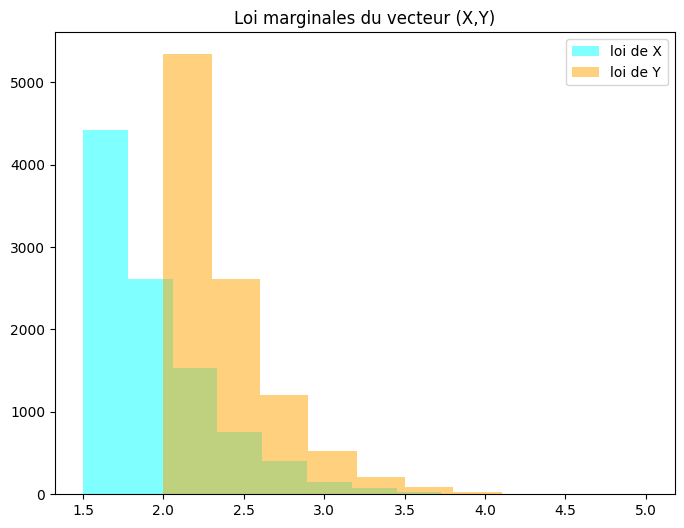

In [157]:
valeurs_de_X = []
valeurs_de_Y = []
temps_acceptation = []
for _ in tqdm(range(n)):
    X, Y, temps = RejectionCoupling_application1(p, q, mu, eta)
    valeurs_de_X.append(X)
    valeurs_de_Y.append(Y)
    temps_acceptation.append(temps)
plt.figure(figsize=(8,6))
plt.scatter(valeurs_de_X, valeurs_de_Y)
plt.xlabel("Vecteur X")
plt.ylabel("Valeurs de Y")
plt.title("Vecteur (X,Y) simulé")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.hist(valeurs_de_X, color = "cyan", alpha = 0.5, label = "loi de X")
plt.hist(valeurs_de_Y, color = "orange", alpha = 0.5,  label = "loi de Y")
plt.title("Loi marginales du vecteur (X,Y)")
plt.legend()
plt.show()

In [159]:
eps = 1e-3  # Seuil epsilon
count = sum(1 for i in range(n) if abs(valeurs_de_X[i] - valeurs_de_Y[i]) < eps)
proba = count / n
print("La probabilité que X = Y est :", proba)

La probabilité que X = Y est : 0.0009


In [14]:
# Calcul de la moyenne empirique
moyenne = np.mean(temps_acceptation)

# Calcul de la variance empirique
variance_empirique = np.mean((temps_acceptation - moyenne) ** 2)

print("Moyenne empirique :", moyenne)
print("Variance empirique :", variance_empirique)
print("Écart-type :", math.sqrt(variance_empirique))

Moyenne empirique : 0.0008691915225982666
Variance empirique : 6.639157224506046e-07
Écart-type : 0.0008148102370801465


## Application 3 : Coupled Gibbs sampling

On considère $ p(x,y) \propto \text{exp} ( - \frac{1}{2} (x ^{T} x . y^{T}y + x ^{T} x + y^{T}y )) $ , $ x, y \in \mathbb{R}^{d}$. 

Après calcul, on trouve que : 

- $p_{x|y}(x) = \mathcal{N}(x ; 0, P_y)$ où $P_y = \frac{1}{1 + y^{T}y} I_d$

- $p_{y|x}(y) = \mathcal{N}(y ; 0, P_x)$ où $P_x = \frac{1}{1 + x^{T}x} I_d$

Grâce à cela, nous pouvons utiliser l'algorithme de Gibbs pour simuler un vecteur aléatoire de loi $p(x,y)$ : 

**Rappel :** 

L'idée de l'algorithme de Gibbs est de rejouer une par une les coordonnées du vecteur selon la loi conditionnelle sachant toutes les autres.

In [29]:
def coupled_gibbs_sampling(initialisation, n_iter):
    """  ReflectionCoupling : simuler p(x, y) en utilisant Gibbs Robert et Casella, 2004, Ch. 4

    --------
    Paramètres :
    initialisation : deux vecteurs x et y de taille d.
    """
    d = len(initialisation[0])  #dimension

    # On commence par initialiser nos vecteurs
    X, Y = [], []
    X.append(initialisation[0])
    Y.append(initialisation[1])
    for _ in range(n_iter):
        #simuler p(x|y)
        P_y = (1 / 1 + linalg.norm(Y[-1]) ** 2) ** 2
        x = stats.multivariate_normal(np.zeros(d), np.eye(d) ** P_y).rvs()

        #simuler p(y|x)
        P_x = (1 / 1 + linalg.norm(x) ** 2) ** 2
        y = stats.multivariate_normal(np.zeros(d), np.eye(d) ** P_x).rvs()

        X.append(x)
        Y.append(y)
    return X, Y

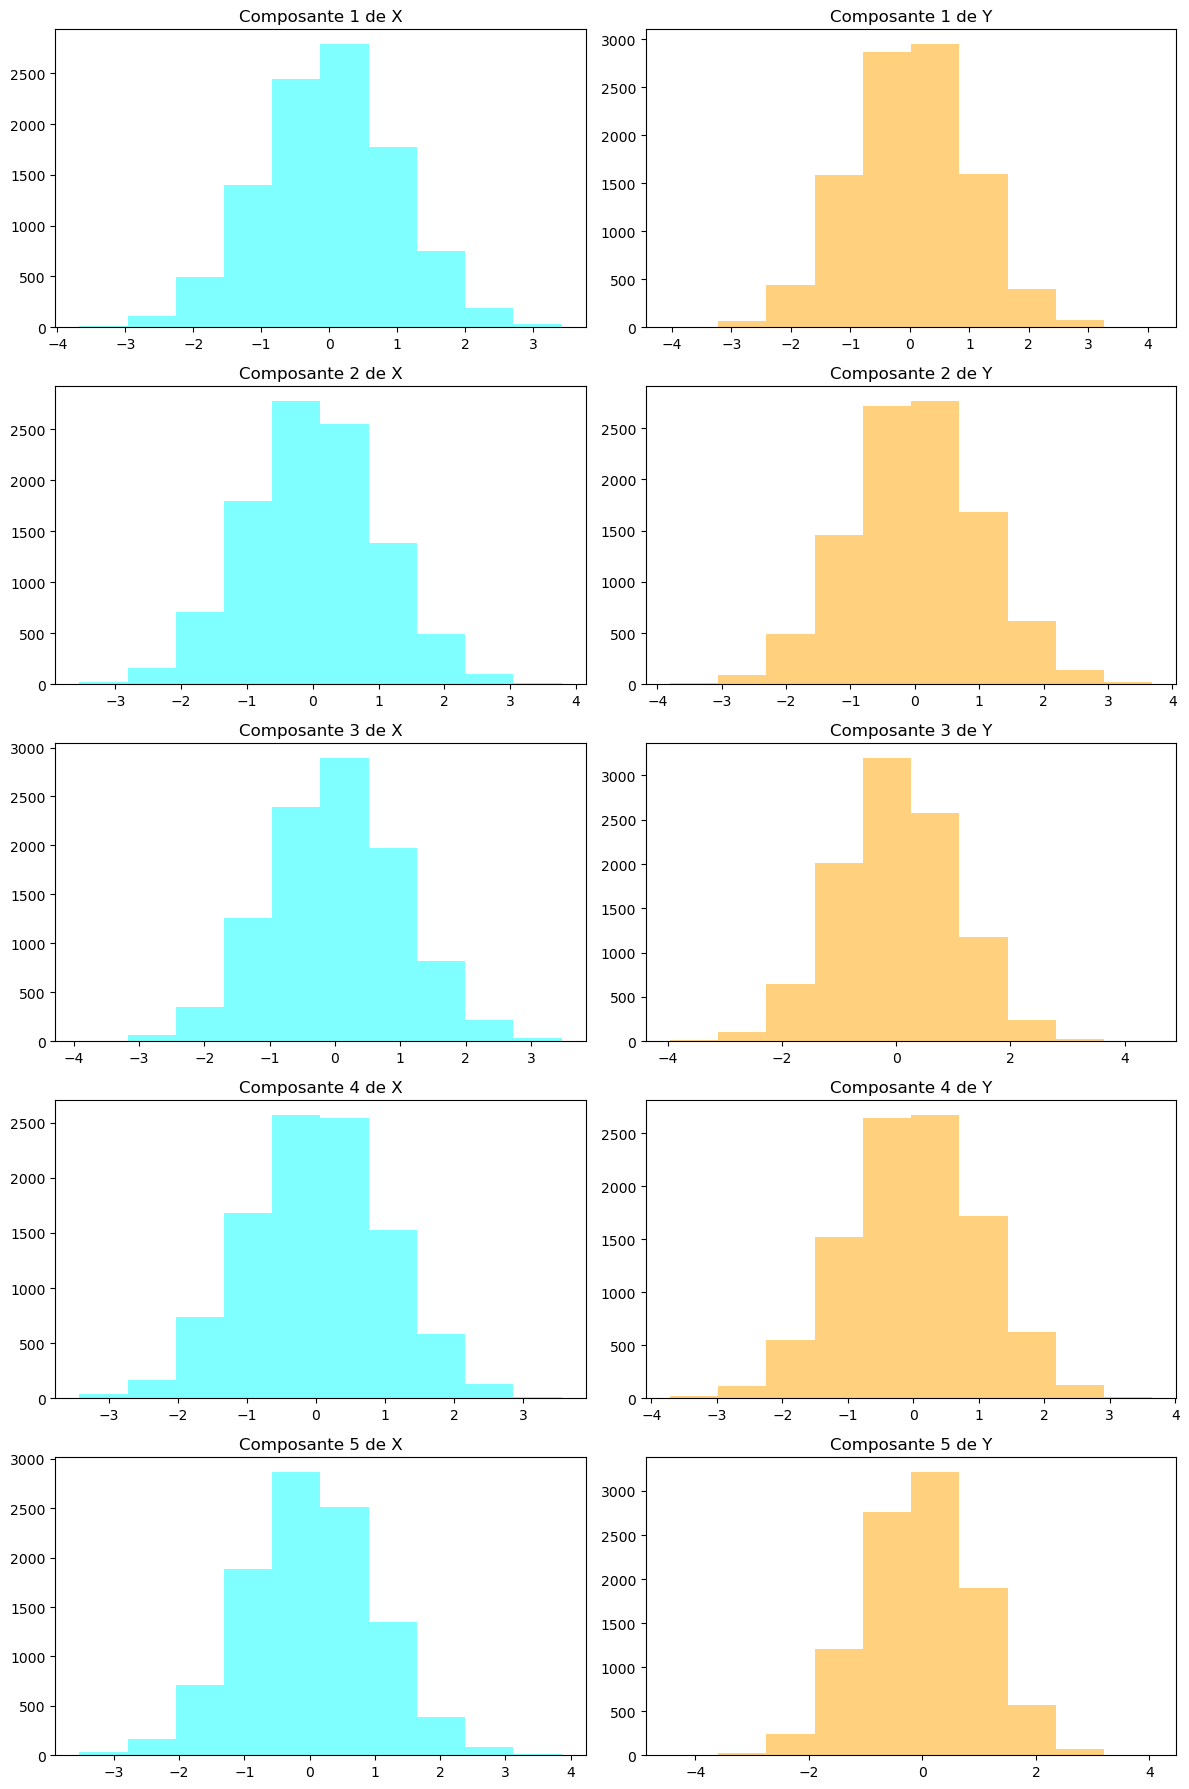

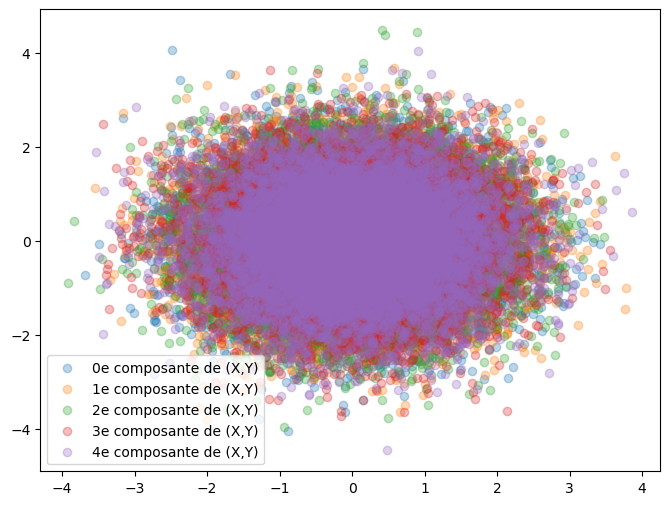

In [30]:
n = 10**4
d = 5
initialisation = np.zeros(d), np.ones(d)
X, Y = coupled_gibbs_sampling(initialisation, n)

valeurs_de_X = np.array(X)
valeurs_de_Y  = np.array(Y)
fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i in range(5):
    axs[i, 0].hist(valeurs_de_X[:,i], color="cyan", alpha=0.5)
    axs[i, 0].set_title(f"Composante {i+1} de X")

    # Affichage de l'histogramme de la i-ème composante de Y
    axs[i, 1].hist(valeurs_de_Y[:,i], color="orange", alpha=0.5)
    axs[i, 1].set_title(f"Composante {i+1} de Y")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
for i in range(5):
    plt.scatter(valeurs_de_X[:,i], valeurs_de_Y[:,i], label = f"{i}e composante de (X,Y)", alpha = 0.3)
plt.legend()
plt.show()

## Application à une marche aléatoire de Metropolis 

In [31]:
def coupled_metropolis_hastings(initialisation, n_iter, taux_acceptation = False):
    """  Simuler p(x, y) en utilisant l'algorithme de Metropolis-Hastings.

    --------
    Paramètres :
    initialisation : deux vecteurs x et y de taille d.
    """
    d = len(initialisation[0])  # Dimension
    c_X, c_Y = 0, 0  # taux d'acceptation

    # On commence par initialiser nos vecteurs
    X, Y = [], []
    X.append(initialisation[0])
    Y.append(initialisation[1])

    for _ in range(n_iter):
        # Proposition
        x_prop = stats.multivariate_normal(mean=np.zeros(d), cov=np.eye(d)).rvs() + Y[-1]
        P_y_x = (1 / (1 + np.linalg.norm(x_prop) ** 2)) ** 2
        P_y = (1 / (1 + np.linalg.norm(X[-1]) ** 2)) ** 2

        # accepter ou rejeter
        ratio = P_y_x / P_y
        U = npr.uniform()
        if U < ratio: #on accepte
            X.append(x_prop)
            c_X += 1
        else: #on rejette 
            X.append(X[-1])

        # Proposition
        y_prop = stats.multivariate_normal(mean=np.zeros(d), cov=np.eye(d)).rvs() + X[-1] 
        P_x_y = (1 / (1 + np.linalg.norm(y_prop) ** 2)) ** 2
        P_x_current = (1 / (1 + np.linalg.norm(Y[-1]) ** 2)) ** 2

        # accepter ou rejeter
        V = npr.uniform()
        ratio2 = P_x_y / P_x_current
        if V < ratio2:
            Y.append(y_prop)
            c_Y += 1
        else:
            Y.append(Y[-1])
    if taux_acceptation:
        return X, Y, c_X / n_iter, c_Y / n_iter
    else: 
        return X, Y

Taux d'acceptation pour X : 0.4603
Taux d'acceptation pour Y : 0.4445


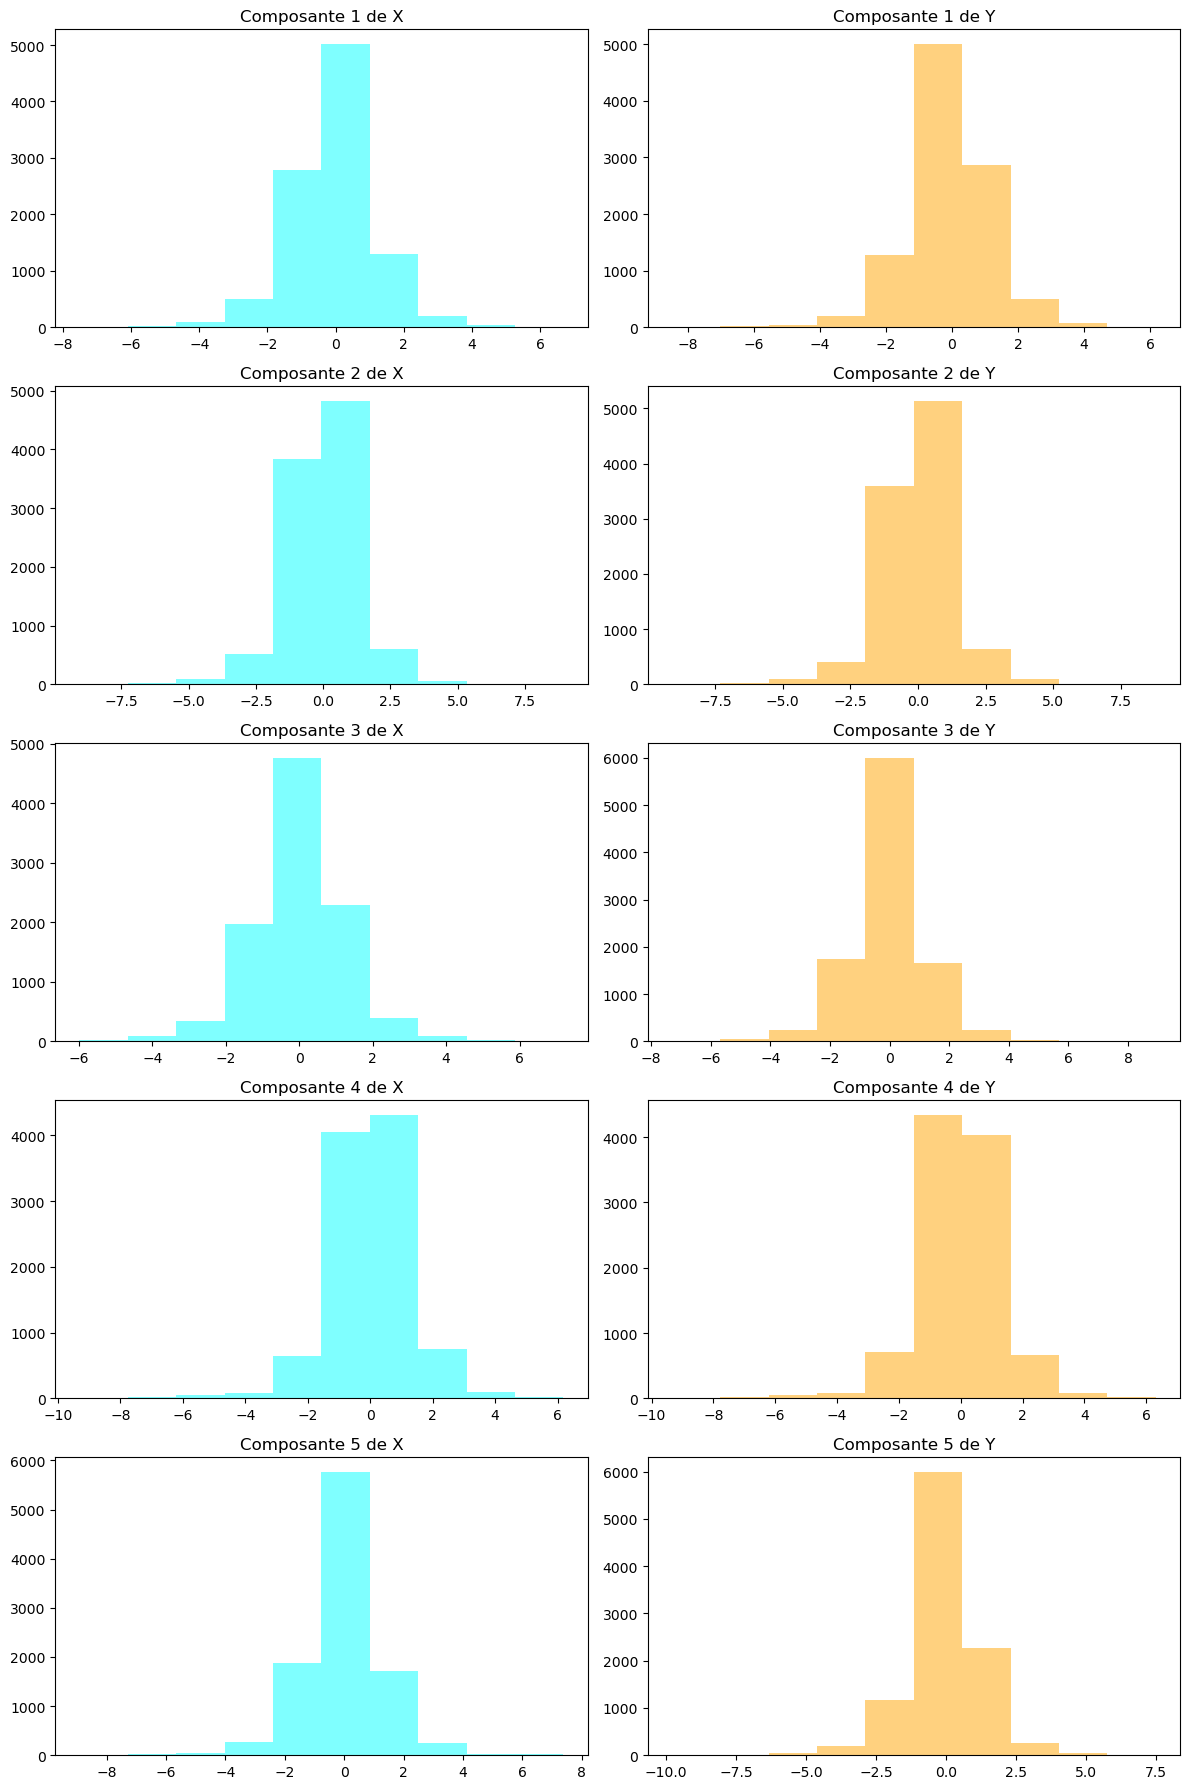

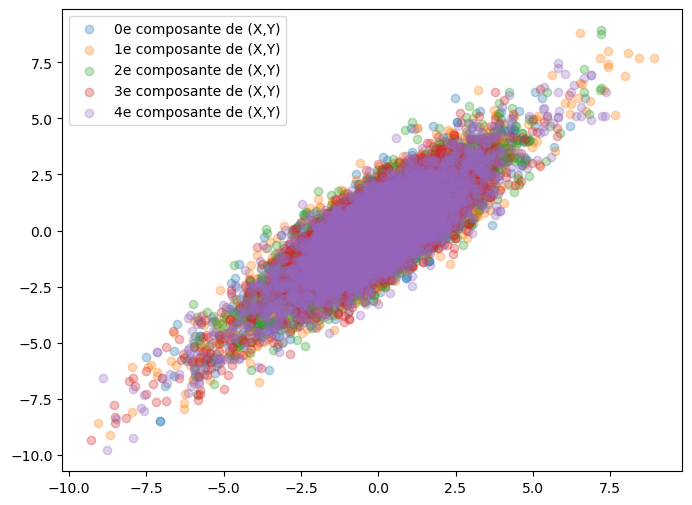

In [32]:
n = 10**4
d = 5
initialisation = np.zeros(d), np.ones(d)
X, Y, c_X, c_Y = coupled_metropolis_hastings(initialisation, n, taux_acceptation=True)

print("Taux d'acceptation pour X :", c_X)
print("Taux d'acceptation pour Y :", c_Y)

valeurs_de_X = np.array(X)
valeurs_de_Y  = np.array(Y)
fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i in range(5):
    axs[i, 0].hist(valeurs_de_X[:,i], color="cyan", alpha=0.5)
    axs[i, 0].set_title(f"Composante {i+1} de X")

    # Affichage de l'histogramme de la i-ème composante de Y
    axs[i, 1].hist(valeurs_de_Y[:,i], color="orange", alpha=0.5)
    axs[i, 1].set_title(f"Composante {i+1} de Y")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
for i in range(5):
    plt.scatter(valeurs_de_X[:,i], valeurs_de_Y[:,i], label = f"{i}e composante de (X,Y)", alpha = 0.3)
plt.legend()
plt.show()

## Algorithme de Thorisson 

Cette approche est valide pour construire une distribution jointe (couplage) pour $(X,Y)$ telle que $X \sim p$, $Y \sim q$ et $ \mathbb{P} (X=Y)$ avec une probabilité élevée.

### **Contexte** : 

Pour réaliser un couplage maximal, on cherche $X^* \sim p(\cdot | X_t)$ et $Y^* \sim p(\cdot | Y_t)$ de manière à maximiser $P(X^* = Y^*)$ parmi l'ensemble des couplages possibles. 
Pour ce faire, si $ p(\cdot | X_t)$ et $ p(\cdot | Y_t)$ sont des distributions gaussiennes de mêmes covariances, alors un algorithme explicite existe.

En revanche, si les covariances sont différentes, on doit se résoudre à utiliser un algorithme d'acceptation-rejet tel que l'algorithme de Thorisson. 

De plus, un couplage maximal vérifie $P(X = Y) = \int_{0}^{1} \min(p(x),q(x))\, dx $. 

Le problème dans ce cas est que la variance du temps d'exécution tend vers l'infini lorsque la loi marginale de X tend vers celle de Y. Or, nous cherchons à contrôler cette variance, c'est pourquoi une approche alternative consiste à échantillonner $X^* \text {et } Y^*$ sous optimaux pour le problème mais avec un contrôle sur le temps d'exécution. 

Dans ce cas, on préfère échantillonner de manière à obtenir  $P(X = Y) = C\int_{0}^{1} \min(p(x),q(x))\, dx $ avec $ 0 < C < 1$ une constante qui contrôle la sous optimalité des distributions échantillonnées. 

### **Algorithme de Thorisson :**

Cet algorithme repose sur le principe d'acceptation-rejet pour un couplage, en tenant compte du prérequis de maximisation de $P(X=Y)$. Pour cela, on choisit d'échantillonner $X \sim p$ comme loi de proposition et on va "fixer" la loi de $X$ afin de bâtir $Y$ tel qu'il maximise le couplage. 

Dans un premier temps, on procède donc à un algorithme d'acceptation-rejet "classique" car on simule de manière uniforme la loi cible de $Y$ à partir de l'aire sous la densité de la propositionnelle $X$. 

- Si $ U < min(\frac{p(x)}{q(x)},C)$, alors on assigne $X \text{ à } Y$.
Cela correspond au fait que si $p(x)$ est relativement grand par rapport à $q(x)$, alors $X$ a plus de chances d'être choisi par rapport à $Y$. 

Ainsi, afin de maximiser le couplage tel que ${X=Y}$, si la distribution de $X$ est dominante, on assigne $X \text{ à } Y$.

- Sinon, on est dans le cas où $p(x)$ n'est pas relativement grand par rapport à $q(x)$ ou bien $ q(x)$ est grand par rapport à $p(x)$. Dans ce cas, $Y$ a plus de chances d'être choisi que $X$, c'est pourquoi on procède à nouveau à une étape d'acceptation-rejet avec $q(z)$ comme propositionnelle car on cherche à accepter plutôt selon la densité $q$. Dans ce cas, si $q(z)$ est relativement grand par rapport à $C*p(z)$, on a plus de chances que $Y$ soit accepté donc afin d'aboutir à un couplage, on assigne $Z$ à $Y$. 

Cet algorithme assure donc que lorsque $p$ est relativement grand devant $q$, on maximise $P(X=Y)$ car on assigne les mêmes valeurs à $X$ et $Y$. 

Sinon, lorsque $q$ est relativement grand devant $p$, on s'assure de choisir ces échantillons avec une probabilité proportionnelle à $\frac{p(z)}{q(z)}$. 

Cette méthode consiste donc en un équilibre entre échantilloner à partir de la densité cible $p$ et la propositionnelle $q$ : en fixant l'une des deux densités, on peut contrôler le couplage de telle sorte que l'autre densité marginale soit proche de la première en couplant. 

### **Le  rôle de $C$ :** 

- Si $C$ est petit, on favorise dans l'algorithme les échantillons où $p \approx q$ de manière à obtenir un couplage correct et on ne rentre pas dans la boucle d'acceptation-rejet. 

- Si $C$ est grand, les lois qui sont très proches les unes des autres ne vont pas être bien différenciées, ce qui nous rapproche d'un couplage maximal mais fait tendre le temps d'exécution vers l'infini.

In [33]:
def ThorissonCoupling(p, q, C):
    X = p.rvs()
    U = np.random.uniform()
    temps_acceptation = []
    if U < min(q.pdf(X) / p.pdf(X), C): 
         Y = X
    else: 
        A = 0
        debut = time.time()
        while A!=1: 
            U = np.random.uniform()
            Z = q.rvs()
            if U > min(1, C * (p.pdf(Z) / q.pdf(Z))):
                A = 1
                Y = Z
        fin = time.time()
        temps_acceptation.append(fin-debut)
    return X,Y,temps_acceptation

100%|██████████| 10000/10000 [00:04<00:00, 2113.77it/s]


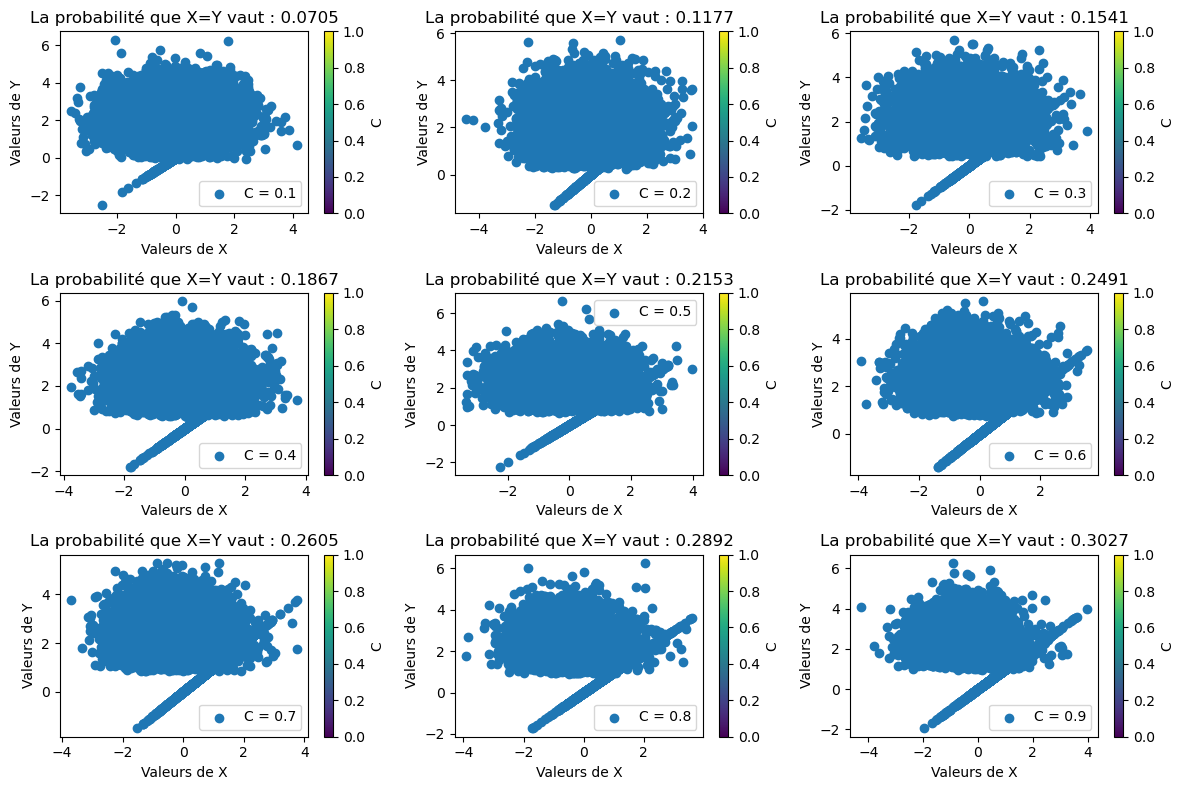

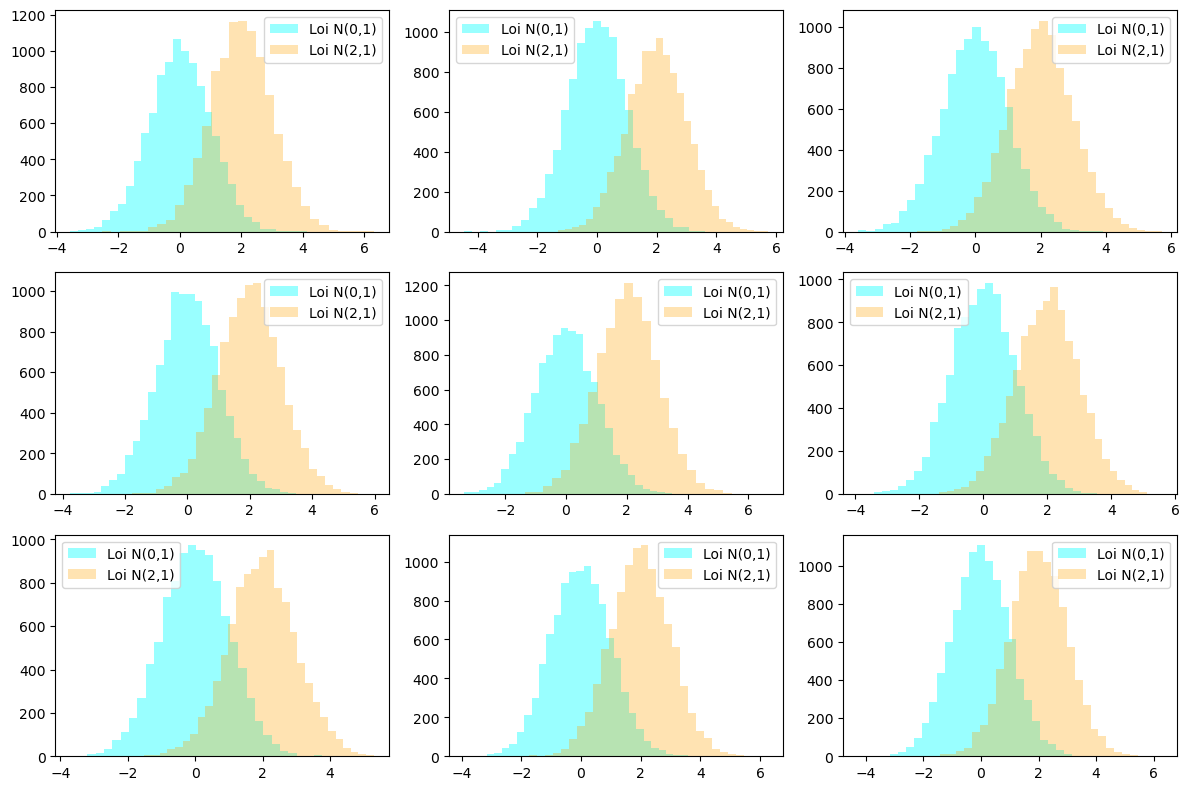

In [34]:
n = 10**4
def create_couple(C):
    c = []
    temps_acceptation = []
    for _ in tqdm(range(n)):
        p = stats.norm(0, 1) 
        q = stats.norm(2, 1) 
        x, y, temps = ThorissonCoupling(p, q, C)
        c.append((x,y))
        temps_acceptation.extend(temps)
    c = np.array(c)
    temps_acceptation = np.array(temps_acceptation)
    return c, temps_acceptation

liste_couples = []
temps_acceptation = []
temps_acceptation_mean_var = []
plt.figure(figsize=(12, 8))
for i, C in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], start=1):
    couple, temps = create_couple(C)
    temps_acceptation.append(temps)
    moyenne = np.mean(temps)
    variance = np.mean((temps - moyenne) ** 2)
    temps_acceptation_mean_var.append([moyenne, variance])
    liste_couples.append(couple)
    plt.subplot(3, 3, i)
    plt.xlabel("Valeurs de X")
    plt.ylabel("Valeurs de Y")
    proba = np.sum(couple[:,0]==couple[:,1]) / len(couple)
    plt.title(f"La probabilité que X=Y vaut : {proba}")
    plt.scatter(couple[:,0], couple[:,1], label = f'C = {C}', cmap='viridis')
    plt.colorbar(label='C')
    plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))
for i, couple in enumerate(liste_couples, start = 1):
    plt.subplot(3, 3, i)
    loi1 = couple[:,0]
    loi2 = couple[:,1]
    plt.hist(loi1, bins=30, label = "Loi N(0,1)", color ="cyan", alpha = 0.4)
    plt.hist(loi2, bins=30, label = "Loi N(2,1)", color ="orange", alpha = 0.3)
    plt.legend()
plt.tight_layout()
plt.show()


On observe bien ici que $P(X=Y)$ croît avec $C$. Cela résulte de l'acceptation-rejet qui est moins contraignante pour $C$ grand. Dans ce cas, on accepte plus d'échantillons couplés selon la diagonale. 

Le temps d'exécution augmente également avec $C$, comme le prévoit l'article. Ce qui justifie le fait d'utiliser $C$ comme facteur de sous-optimalité pour le couplage. 

In [124]:
# Récupérer les premiers termes dans une liste de moyennes
means = [x[0] for x in temps_acceptation_mean_var]
# Récupérer les deuxièmes termes dans une liste de variances
variances = [x[1] for x in temps_acceptation_mean_var]
print("Liste de moyennes :", means)
print("Liste de variances :", variances)
print("Liste des temps d'acceptation :", temps_acceptation)


Liste de moyennes : [0.00040706526437707624, 0.00039559069004925816, 0.0004074377962253068, 0.0004301353473568437, 0.0005131070948366067, 0.0005586326356640337, 0.0005764331573926026, 0.0006037036762524954, 0.0005822878325554811]
Liste de variances : [3.7780415125885036e-06, 3.6169541074512254e-06, 3.496135281155821e-06, 4.0043198476074146e-06, 3.6854066487024528e-06, 3.6287619757594304e-06, 4.439620900400328e-06, 3.09444905138971e-06, 4.4470004826755585e-06]
Liste des temps d'acceptation : [array([0.        , 0.        , 0.        , ..., 0.        , 0.00099969,
       0.        ]), array([0.        , 0.        , 0.        , ..., 0.00099564, 0.        ,
       0.        ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.0010016 , 0.00059676, 0.0009985 , ..., 0.        , 0.        ,
       0.00113535]), array([0.00940752, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]), array([0.        , 0.        , 0.00159883, ..., 0.     

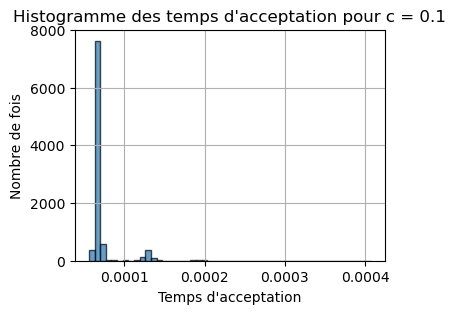

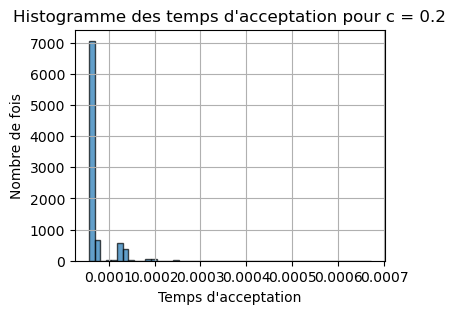

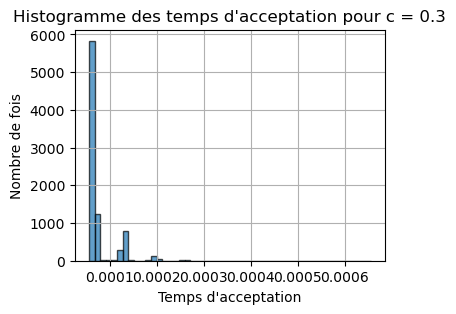

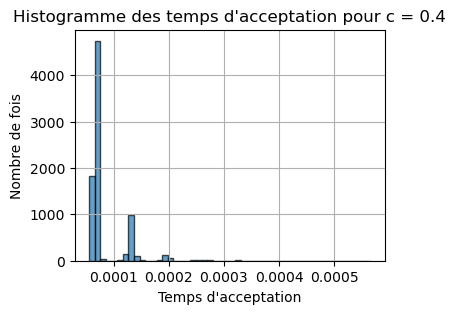

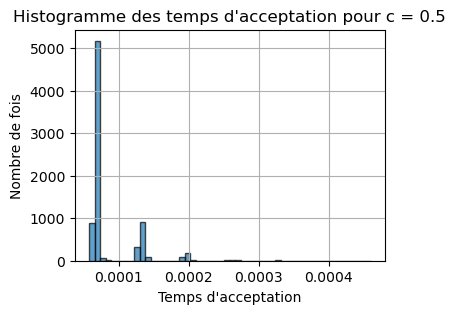

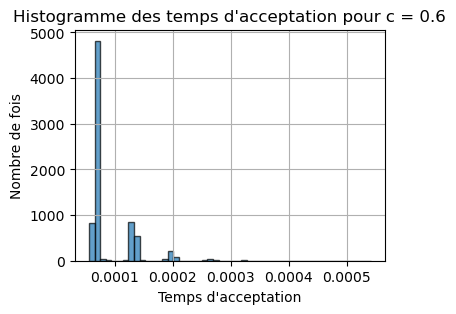

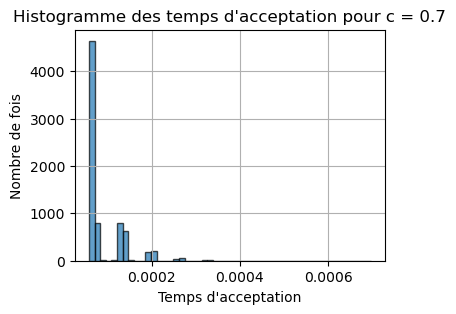

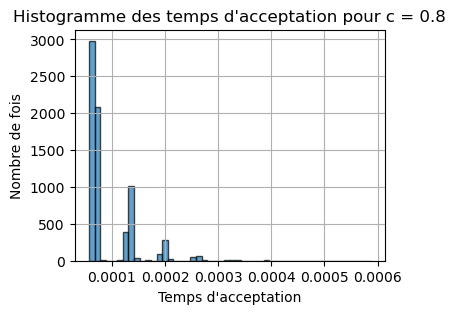

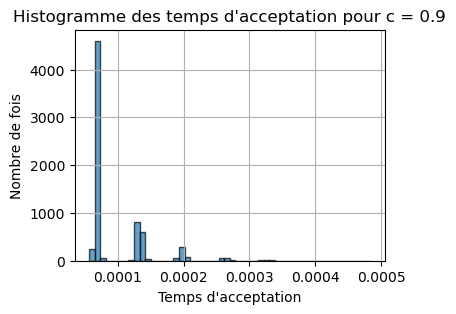

In [39]:
# Tracer un histogramme pour chaque ensemble de temps d'acceptation
for i, temps in enumerate(temps_acceptation, start=1):
    plt.figure(figsize=(4,3))
    plt.hist(temps, bins=50, edgecolor='black', alpha=0.7)
    plt.title(f'Histogramme des temps d\'acceptation pour c = 0.{i}')
    plt.xlabel('Temps d\'acceptation')
    plt.ylabel('Nombre de fois')
    plt.grid(True)
    plt.show()

Pour chaque $C$, on vérifie que les temps d'acceptation de l'algorithme sont aléatoires, en utilisant le test du $\chi_2$, en découpant la variable continue $temps\_acceptation$ en intervalle. On a effectué les tests d'adéquation avec une loi uniforme. Étant donné que le temps d'acceptation en acceptation-rejet suit une loi géométrique de paramètre $\frac{1}{M}$ où $M$ est la borne du ratio entre la loi cible et la propositionnelle, il pourrait être intéressant de considérer une telle loi géométrique.

In [111]:
import scipy.stats as stats

def chi_square_test_continuous(data, bins=100):
    observed, _ = np.histogram(data, bins=bins)
    expected = np.full_like(observed, fill_value=len(data) / bins)
    chi_squared_stat = ((observed - expected) ** 2 / expected).sum()
    p_value = 1 - stats.chi2.cdf(chi_squared_stat, df=bins - 1)
    return chi_squared_stat, p_value

for i, C in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], start=0):
    data = temps_acceptation[i]
    # Effectuer le test du chi-deux
    chi_squared_stat, p_value = chi_square_test_continuous(data)
    degrees_of_freedom = len(data) - 1
    print("Statistique de test du chi-deux :", chi_squared_stat)
    print("Degrés de liberté :", degrees_of_freedom)
    print("P-value :", p_value)


Statistique de test du chi-deux : 686984.1847826086
Degrés de liberté : 9282
P-value : 0.0
Statistique de test du chi-deux : 735496.724137931
Degrés de liberté : 8786
P-value : 0.0
Statistique de test du chi-deux : 680082.4337349398
Degrés de liberté : 8387
P-value : 0.0
Statistique de test du chi-deux : 596899.3500000001
Degrés de liberté : 8097
P-value : 0.0
Statistique de test du chi-deux : 558375.3333333335
Degrés de liberté : 7851
P-value : 0.0
Statistique de test du chi-deux : 443228.00000000006
Degrés de liberté : 7467
P-value : 0.0
Statistique de test du chi-deux : 361175.89189189195
Degrés de liberté : 7421
P-value : 0.0
Statistique de test du chi-deux : 388229.8333333333
Degrés de liberté : 7201
P-value : 0.0
Statistique de test du chi-deux : 355515.0428571431
Degrés de liberté : 7008
P-value : 0.0


Le résultat obtenu est une statistique de test du chi-deux élevée et une p-value très proche de zéro dans chaque cas. Cela suggère fortement que les données ne suivent pas une distribution uniforme.

Plus précisément, la statistique de test du chi-deux est une mesure de l'écart entre les fréquences observées dans chaque bin et les fréquences attendues si les données suivaient une distribution aléatoire. Plus cette statistique est élevée, plus les données diffèrent de l'hypothèse d'une distribution aléatoire. La p-value est la probabilité d'observer une statistique de test au moins aussi extrême que celle observée si l'hypothèse nulle (les données suivent une distribution uniforme) est vraie. Une p-value proche de zéro signifie que l'hypothèse nulle peut être rejetée avec une forte confiance.

En conclusion, le résultat suggère que les échantillons testés ne sont pas aléatoires et ne suivent pas une distribution uniforme, ce qui est contradictoire avec ce que l'on devrait trouver.

## Comparaison entre l'approche de Thorisson et l'algorithme proposé dans l'article

On reprend l'exemple proposé dans la partie "Méthode d'échantillonnage par rejet couplé" dans lequel on souhaite coupler deux lois normales $\mathcal{N}(0,1)$. 

Pour rappel, on majore les densités $p(x) = q(x) = \frac{1}{\sqrt{2 \pi}} e^{- \frac{x ^2}{2}}$ par $ \hat{p} (x) = \hat{q} (x) = 2 e^{-2x}$, et on prend $M = \sqrt{ \frac{2}{ \pi}} e^{2}$, pour appliquer l'algorithme Rejection-coupling.

### Temps d'exécution

On observe que le temps d'exécution augmente plus rapidement avec l'algorithme de Thorisson pour $C=1$ par rapport à l'algorithme pour $C < 1$. Les taux d'acceptation suivent une loi géométrique de paramètre l'inverse de la borne de couplage.